# Categorical Feature Encoding Challenge

This is a fun Kaggle challenge. Here is the link to the [challenge](https://www.kaggle.com/c/cat-in-the-dat) to explore the dataset yourself. In this challenge, I work with several different types of categorical features in order to encode them in a format that allows as much useful signal as possible to be captured. The categorical features in this dataset include:
<ul>
  <li>binary features</li>
  <li>low- and high-cardinality nominal features</li>
  <li>low- and high-cardinality ordinal features</li>
  <li>(potentially) cyclical features </li>
</ul>

In [1]:
import pandas as pd # linear algebra
pd.set_option('max_columns', None)
import numpy as np # data processing

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import FeatureHasher

import seaborn as sns

## Data Exploration

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Here, I can see that the training set has 300,000 rows and the test set has 200,000

In [3]:
print("Training set shape: {} \nTest set shape: {}".format(df_train.shape, df_test.shape))

Training set shape: (300000, 25) 
Test set shape: (200000, 24)


Below I can see the number of unique values for each column in the dataset. We can see that we have 5 binary columns, 10 nominal columns, 6 ordinal columns, and then 2 potentially time series columns (day and month).

In [4]:
for col in df_train.columns:
    if (col != "id") and (len(df_train[col].unique())<=7):
        print(str(col) + "  \tunique values: " + str(df_train[col].nunique()) + "\t \t \t categories: " + str(df_train[col].unique()))
    elif (col!="id"):
        print(str(col) + "  \tunique values: " + str(df_train[col].nunique()))

bin_0  	unique values: 2	 	 	 categories: [0 1]
bin_1  	unique values: 2	 	 	 categories: [0 1]
bin_2  	unique values: 2	 	 	 categories: [0 1]
bin_3  	unique values: 2	 	 	 categories: ['T' 'F']
bin_4  	unique values: 2	 	 	 categories: ['Y' 'N']
nom_0  	unique values: 3	 	 	 categories: ['Green' 'Blue' 'Red']
nom_1  	unique values: 6	 	 	 categories: ['Triangle' 'Trapezoid' 'Polygon' 'Square' 'Star' 'Circle']
nom_2  	unique values: 6	 	 	 categories: ['Snake' 'Hamster' 'Lion' 'Cat' 'Dog' 'Axolotl']
nom_3  	unique values: 6	 	 	 categories: ['Finland' 'Russia' 'Canada' 'Costa Rica' 'China' 'India']
nom_4  	unique values: 4	 	 	 categories: ['Bassoon' 'Piano' 'Theremin' 'Oboe']
nom_5  	unique values: 222
nom_6  	unique values: 522
nom_7  	unique values: 1220
nom_8  	unique values: 2215
nom_9  	unique values: 11981
ord_0  	unique values: 3	 	 	 categories: [2 1 3]
ord_1  	unique values: 5	 	 	 categories: ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2  	unique values: 6	

Next, I'm going to take a closer look at the data by viewing the first 5 lines in order to get a better understanding of the columns with higher numbers of categories. Based upon this function, nom_5 through nom_9 seem to be combinations of numbers and letters which have no particular order whereas ord_3 through ord_5 are ordered alphabetically. This would make sense based upon the titles of the columns. Here are some definitions for background:
<br>
<br> <b> Nominal - </b> has no order. Therefore changing the order of its values would not change the meaning 
<br> <b> Ordinal - </b> represents discrete and ordered units. It is different from nominal data because the ordering matters
<br> <b> Time Series - </b> a sequence of data points indexed in time order.

In [5]:
df_train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


From the below code, I can see that there are no missing values in this dataset.

In [6]:
df_train.isnull().sum()

id        0
bin_0     0
bin_1     0
bin_2     0
bin_3     0
bin_4     0
nom_0     0
nom_1     0
nom_2     0
nom_3     0
nom_4     0
nom_5     0
nom_6     0
nom_7     0
nom_8     0
nom_9     0
ord_0     0
ord_1     0
ord_2     0
ord_3     0
ord_4     0
ord_5     0
day       0
month     0
target    0
dtype: int64

Now that I have a high-level understanding of the data, I want to see the distribution of the target variable. This shows that we have an imbalanced dataset where 69% of the target values are 0 and 31% of the target values are 1.

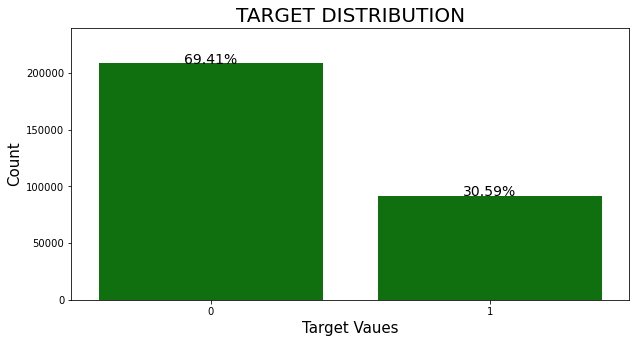

In [7]:
total = len(df_train)
plt.figure(figsize=(10,5))

g = sns.countplot(x='target', data=df_train, color='green')
g.set_title("TARGET DISTRIBUTION", fontsize = 20)
g.set_xlabel("Target Vaues", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
sizes=[] # Get highest values in y
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.show()

# Feature Engineering
First, I'm going to set up my X and y

In [8]:
X = df_train.drop(columns=['id', 'target'])
y = df_train['target']

test = df_test.drop(columns=['id'])

labels = X.columns
IDs = df_test['id']

I'm going to be treating the columns differently depending on whether they are binary, ordinal, nominal, or time series. In order to separate out the columns, I'm going to use list comprehensions. For binary, ordinal, and nominal I can simply sort them by checking what the column name starts with. Then the time series columns are whatever columns are left over.

In [9]:
bin_cols = [col for col in X.columns.values if col.startswith('bin')]
nom_cols = [col for col in X.columns.values if col.startswith('nom')]
ord_cols = [col for col in X.columns.values if col.startswith('ord')]

time_series_cols = [col for col in X.columns.values if col not in bin_cols + nom_cols + ord_cols]

## Nominal Columns: Label Encoding vs. One Hot Encoding
The purpose of encoding the columns is because most algorithms can not work with categorical data. They only work with numerical data. There are a few exceptions to this though, such as CatBoost, which accepts categorical data.

<b> Label Encoding </b> converts the categories into numbers by giving each category a numerical value between 0 and n_classes-1 where n is the number of distinct labels. The problem with label encoding is that, since there are different numbers in the same column, the model will misunderstand the data to be in some kind of order, 0 < 1 <2. This is alright if the column actually has order. But if the column doesn't have order, then the algorithm may make some incorrect correlations that don't generalize to the real world.

<b> One Hot Encoding </b> on the other hand takes all of the categories in a column and then creates a new column for each of those categories. Each of these categories is binary. It is either 0 or 1. Doing this solves the problem of the algorithm potentially misunderstanding that the data is in some order because now each of the categories has it's own column. One potential downside of One Hot Encoding is that the dataset can become large very quickly if a column with a lot of categories is encoded this way. For example, if a column that has 100 categories is one hot encoded, then the resulting dataset will have 100 additional columns than it had before. There are some ways to limit the computational impact of this, such as converting to a sparse matrix, but this is still something to keep in mind when one hot encoding.

I'm going to label encode the binary columns since there is no order in a binary column. Additionally, I'm going to label encode the nominal columns which have 222 or more unique categories. As stated previously, label encoding a nominal column might confuse the model into thinking there is order when there actually isn't. However, since there are 222 or more categories, one hot encoding would add hundreds of columns and make my dataset grow very large. In the interest of computational efficiency, I'm making the decision to label encode those columns.

The reason that I created an encoders_dict is so that I can keep all of the encoders that were used to encode this data. Then, I can use those encoders to encode the test data in the exact same way that I encoded the training data. That way, I can use the same processes to convert the test data to numbers as I did for the training data.

In [10]:
encoders_dict = {}

def encode_col(df, col):
    le = LabelEncoder()
    df[col] = le.fit_transform(X[col])
    encoders_dict[col] = le

for col in bin_cols + nom_cols:
    if (X[col].dtype == "object") and (X[col].nunique() >= 222):
        encode_col(X, col)
    elif (X[col].dtype == "object") and (X[col].nunique() == 2):
        encode_col(X, col)
    else:
        X[col] = X[col]

X.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0,0,1,1,Green,Triangle,Snake,Finland,Bassoon,78,120,491,1686,2175,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,1,1,Green,Trapezoid,Hamster,Russia,Piano,159,510,260,650,11635,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,0,1,Blue,Trapezoid,Lion,Russia,Theremin,44,14,766,1932,8078,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,0,1,Red,Trapezoid,Snake,Canada,Oboe,209,165,1121,629,6056,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,0,0,Red,Trapezoid,Lion,Canada,Oboe,90,61,34,1760,8231,1,Grandmaster,Freezing,a,R,qP,7,8


Next, I am going to one hot encode the rest of the nominal columns. Since these columns have 6 or fewer categories, they won't make my dataset overly large so they are good candidates for one hot encoding. In the hyperparameters, I set the OneHotEncoder to have sparse = False since I will be appending this dataFrame to the original dataset which is not sparse.

In [11]:
# Create list of columns that will be one hot encoded
ohe_cols = []
for col in nom_cols:
    if X[col].dtype == "object":
        ohe_cols.append(col)

In [12]:
# Create the one hot encoded dataframe using pd.get_dummies()
ohe_df = pd.get_dummies(X[ohe_cols])

# Join the columns from the one hot encoded dataframe to the training dataframe
X = X.join(ohe_df)

# Drop the old columns
X.drop(ohe_cols, axis=1, inplace=True)

In [13]:
X.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin
0,0,0,0,1,1,78,120,491,1686,2175,2,Grandmaster,Cold,h,D,kr,2,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
1,0,1,0,1,1,159,510,260,650,11635,1,Grandmaster,Hot,a,A,bF,7,8,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,1,44,14,766,1932,8078,1,Expert,Lava Hot,h,R,Jc,7,2,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,0,1,0,0,1,209,165,1121,629,6056,1,Grandmaster,Boiling Hot,i,D,kW,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,90,61,34,1760,8231,1,Grandmaster,Freezing,a,R,qP,7,8,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


## Ordinal Columns: Encoding with Dictionaries

Since the ordinal columns actually have order, I will be encoding them in their correct order using dictionaries. First, I'll take a look at how many unique values are in each of the ordinal columns. The ord_0 column will not need to be encoded, since it is already in numerical order. The rest of the columns will be encoded using a dictionary.

In [14]:
for col in ord_cols:
    print(str(col) + "\t dtype: " + str(X[col].dtype) + "   \t unique values: " + str(X[col].nunique()))

ord_0	 dtype: int64   	 unique values: 3
ord_1	 dtype: object   	 unique values: 5
ord_2	 dtype: object   	 unique values: 6
ord_3	 dtype: object   	 unique values: 15
ord_4	 dtype: object   	 unique values: 26
ord_5	 dtype: object   	 unique values: 192


In [15]:
ord_1_dictionary = {'Novice':0,'Contributor':1,'Expert':2,'Master':3,'Grandmaster':4}
X['ord_1'] = X['ord_1'].map(ord_1_dictionary)

In [16]:
ord_2_dictionary = {'Freezing':0,'Cold':1,'Warm':2,'Hot':3,'Boiling Hot':4,'Lava Hot':5}
X['ord_2'] = X['ord_2'].map(ord_2_dictionary)

ord_3, ord_4, and ord_5 are all alphabetical columns. It was relatively quick to convert these to a dictionary by getting the list of unique values, pulling that into Notepad++ in order to use macros to remove the quotation marks and commas. Then pulling that into excel in order to use the filters to order alphabetically, then finally pulling back into Notepad++ in order to use macros to put the data in the proper format for a dictionary.

In [17]:
ord_3_dictionary = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7,'i':8,'j':9,'k':10,'l':11,'m':12,'n':13,'o':14}
X['ord_3'] = X['ord_3'].map(ord_3_dictionary)

In [18]:
ord_4_dictionary = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25}
X['ord_4'] = X['ord_4'].map(ord_4_dictionary)

In [19]:
ord_5_dictionary = {'ac':1,'av':2,'be':3,'ck':4,'cp':5,'dh':6,'eb':7,'eg':8,'ek':9,'ex':10,'fh':11,'hh':12,'hp':13,'ih':14,'je':15,
'jp':16,'ke':17,'kr':18,'kw':19,'ll':20,'lx':21,'mb':22,'mc':23,'mm':24,'nh':25,'od':26,'on':27,'pa':28,'ps':29,'qo':30,
'qv':31,'qw':32,'ri':33,'rp':34,'sn':35,'su':36,'tv':37,'ud':38,'us':39,'ut':40,'ux':41,'uy':42,'vq':43,'vy':44,
'wu':45,'wy':46,'xy':47,'yc':48,'aF':49,'aM':50,'aO':51,'aP':52,'bF':53,'bJ':54,'cA':55,'cG':56,'cW':57,'dB':58,
'dE':59,'dN':60,'dO':61,'dP':62,'dQ':63,'dZ':64,'eG':65,'eQ':66,'fO':67,'gJ':68,'gM':69,'hL':70,'hT':71,'iT':72,
'jS':73,'jV':74,'kC':75,'kE':76,'kK':77,'kL':78,'kU':79,'kW':80,'lF':81,'lL':82,'nX':83,'oC':84,'oG':85,'oH':86,
'oK':87,'qA':88,'qJ':89,'qK':90,'qP':91,'qX':92,'rZ':93,'sD':94,'sV':95,'sY':96,'tM':97,'tP':98,'uJ':99,'uS':100,
'vK':101,'xP':102,'yN':103,'yY':104,'zU':105,'Ai':106,'Aj':107,'Bb':108,'Bd':109,'Bn':110,'Cl':111,'Dc':112,'Dx':113,'Ed':114,
'Eg':115,'Er':116,'Fd':117,'Fo':118,'Gb':119,'Gx':120,'Hj':121,'Id':122,'Jc':123,'Jf':124,'Jt':125,'Kf':126,'Kq':127,'Mf':128,
'Ml':129,'Mx':130,'Nf':131,'Nk':132,'Ob':133,'Os':134,'Ps':135,'Qb':136,'Qh':137,'Qo':138,'Rm':139,'Ry':140,'Sc':141,'To':142,
'Uk':143,'Uu':144,'Vf':145,'Vx':146,'Wc':147,'Wv':148,'Xh':149,'Xi':150,'Yb':151,'Ye':152,'Zc':153,'Zq':154,'AP':155,'BA':156,
'BE':157,'CL':158,'CM':159,'CU':160,'CZ':161,'DH':162,'DN':163,'FI':164,'GD':165,'GJ':166,'IK':167,'JX':168,'KR':169,'KZ':170,
'LE':171,'MC':172,'MO':173,'MV':174,'NV':175,'OR':176,'PA':177,'PQ':178,'PZ':179,'QM':180,'RG':181,'RL':182,'RP':183,'SB':184,
'TR':185,'TZ':186,'UO':187,'WE':188,'XI':189,'YC':190,'ZR':191,'ZS':192}
X['ord_5'] = X['ord_5'].map(ord_5_dictionary)

In [20]:
ords_dict={'ord_1':ord_1_dictionary,'ord_2':ord_2_dictionary,'ord_3':ord_3_dictionary,'ord_4':ord_4_dictionary,'ord_5':ord_5_dictionary}

In [21]:
X.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin
0,0,0,0,1,1,78,120,491,1686,2175,2,4,1,7,3,18,2,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
1,0,1,0,1,1,159,510,260,650,11635,1,4,3,0,0,53,7,8,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,1,44,14,766,1932,8078,1,2,5,7,17,123,7,2,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,0,1,0,0,1,209,165,1121,629,6056,1,4,4,8,3,80,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,90,61,34,1760,8231,1,4,0,0,17,91,7,8,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [22]:
X.dtypes

bin_0               int64
bin_1               int64
bin_2               int64
bin_3               int32
bin_4               int32
nom_5               int32
nom_6               int32
nom_7               int32
nom_8               int32
nom_9               int32
ord_0               int64
ord_1               int64
ord_2               int64
ord_3               int64
ord_4               int64
ord_5               int64
day                 int64
month               int64
nom_0_Blue          uint8
nom_0_Green         uint8
nom_0_Red           uint8
nom_1_Circle        uint8
nom_1_Polygon       uint8
nom_1_Square        uint8
nom_1_Star          uint8
nom_1_Trapezoid     uint8
nom_1_Triangle      uint8
nom_2_Axolotl       uint8
nom_2_Cat           uint8
nom_2_Dog           uint8
nom_2_Hamster       uint8
nom_2_Lion          uint8
nom_2_Snake         uint8
nom_3_Canada        uint8
nom_3_China         uint8
nom_3_Costa Rica    uint8
nom_3_Finland       uint8
nom_3_India         uint8
nom_3_Russia

# Predictions
Now I'm going to make predictions using a variety of different algorithms. My goal here is to find out how each of the different algorithms perform against each other. 

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif

In [24]:
# SGD Classifier
SGDClassifier = SGDClassifier(loss = 'log', 
                              penalty = 'l1',
                              learning_rate = 'optimal',
                              random_state = 10, 
                              max_iter=100)

# Random Forest Classifier
random_forest = RandomForestClassifier()

# Extra Trees Classifier
extra_trees = ExtraTreesClassifier()

# K Nearest Neighbors Classifier
KNeighborsModel = KNeighborsClassifier(n_neighbors = 4,
                                       weights = 'distance',
                                       algorithm = 'brute')

# Bernoulli Naieve Bayes Classifier
bernoulliNBModel = BernoulliNB(alpha=0.1)

# eXtreme Gradient Boosting Classifier
xgb = XGBClassifier(learning_rate =0.1,
                    n_estimators=250,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

## Define a Function to Easily Check the Performance of Different Models
I'm going to use StratifiedShuffleSplit to check the accuracy of the models over several cross validation folds. My function allows me to select the number of folds to use and then splits the data into a training set which is 80% of the data and a test set which is 20% of the data. Then it prints out the accuracy of the model for each fold and returns the average score over all of the folds.

In order to have balance between the classes in my dataset, there are two strategies that I could try. I could oversample or undersample the data. There are other variations of sampling that I could use, such as Synthetic Minority OverSampling (SMOTE). In this project, I'm going to explore how the results are impacted with using RandomOverSampler as compared to RandomUnderSampler.

An important point here is to only oversample/undersample the training data, and not the test data. This is because I want to be able to see how the model will perform on the real data, without making modifications to it.

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import statistics
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

C:\Users\lhm\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


### Accuracy vs ROC AUC
Accuracy is the most widely used classification metric. But accuracy is almost universally inappropriate for imbalanced classification such as in this problem here. The reason is a high accuracy is achievable by a no skill model that only predicts the majority class.

In the framework of imbalanced data sets, accuracy is not a good measure since it does not distinguish between the numbers of correctly classified examples of different classes which may lead to erroneous conclusions. This is called the accuracy paradox.

The ROC curve evaluates classifiers based on how effective they are at separating classes. The ROC curve is the most commonly used threshold metric. With the ROC AUC curve, a no-skill classifier would achieve a score of 0.5 and a perfect score would be 1.

Because this dataset is imbalanced, I'm going to use the ROC AUC score instead of accuracy.

In [26]:
# split the Label Encoded DataFrame into a training and test set, oversample the traning set using RandomoverSampler
# function implements stratified shuffle split to perform cross validation and allows me to define a certain number of splits and the input DataFrame
@ignore_warnings(category=ConvergenceWarning)
def classifier_roc_test(n_splits, input_df, input_y, classifier, sample_type):
    sss = StratifiedShuffleSplit(n_splits = n_splits, test_size = 0.2, random_state = 0)
    scores = []
    for train_index, test_index in sss.split(input_df, input_y):
        X_train, X_test = input_df.loc[train_index,:], input_df.loc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if sample_type == "oversample":
            ros = RandomOverSampler(random_state=0)
            X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
        
        if sample_type == "undersample":
            rus = RandomUnderSampler(random_state=0)
            X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        
        classifier.fit(X_resampled, y_resampled)
        y_pred = classifier.predict(X_test)
        roc = roc_auc_score(y_pred, y_test)
        scores.append(roc)
        #print(round(roc, 4))
    return round(statistics.mean(scores), 4)

## Checking Accuracy of Different Models and Comparing RandomOverSampler with RandomUnderSampler

Based upon these experiments, I can see that oversampling consistently performed better on all models except bernoulliNBModel. The top classifier was random_forest utilizing oversampling. I will use this classifier in order to make predictions on the test set.

In [27]:
# create DataFrame where I will be storing all of the scores
classifier_performance = pd.DataFrame(columns = ['classifier','sample_type', 'roc_score'])

# create a dictionary containing all of the classifiers that I will be comparing
classifier_dict = {"SGDClassifier":SGDClassifier,"random_forest":random_forest,"extra_trees":extra_trees,
                   "KNeighborsModel":KNeighborsModel,"bernoulliNBModel":bernoulliNBModel,"xgb":xgb}

In [28]:
# iterate through every classifier in the dictionary, test the ROC AUC scores using oversampling and undersampling
# store all of the results in a DataFrame
for classifier in classifier_dict.keys():
    roc_performance_oversample = classifier_roc_test(5, X, y, classifier_dict[classifier], sample_type ="oversample")
    new_oversample_row = pd.DataFrame( {'classifier':[classifier],'sample_type':['oversample'], 'roc_score':[roc_performance_oversample]})
    classifier_performance = classifier_performance.append(new_oversample_row)
    print(classifier + " oversample is completed")
    
    roc_performance_undersample = classifier_roc_test(5, X, y, classifier_dict[classifier],sample_type= "undersample")
    new_undersample_row = pd.DataFrame( {'classifier':[classifier],'sample_type':['undersample'], 'roc_score':[roc_performance_undersample]})
    classifier_performance = classifier_performance.append(new_undersample_row)
    print(classifier + " undersample is completed")

# reset the index of the new dataframe
classifier_performance.reset_index(inplace=True, drop=True)

SGDClassifier oversample is completed
SGDClassifier undersample is completed
random_forest oversample is completed
random_forest undersample is completed
extra_trees oversample is completed
extra_trees undersample is completed
KNeighborsModel oversample is completed
KNeighborsModel undersample is completed
bernoulliNBModel oversample is completed
bernoulliNBModel undersample is completed
xgb oversample is completed
xgb undersample is completed


In [29]:
classifier_performance['Classifier_Sample_Type'] = classifier_performance['classifier'] +" " + classifier_performance['sample_type']

From here I can see that oversampling performed better on average over all of the scores

In [30]:
classifier_performance.groupby(by='sample_type').mean()

,roc_score
sample_type,
oversample,0.6290
undersample,0.6165


From here I can see that the top scoring classifier for both oversampling and undersampling was xgb

In [31]:
classifier_performance.groupby(by='sample_type').max()

,classifier,roc_score,Classifier_Sample_Type
sample_type,,,
oversample,xgb,0.6892,xgb oversample
undersample,xgb,0.6716,xgb undersample


Here is the DataFrame containing all of the scores

In [32]:
classifier_performance

,classifier,sample_type,roc_score,Classifier_Sample_Type
0,SGDClassifier,oversample,0.6168,SGDClassifier oversample
1,SGDClassifier,undersample,0.6091,SGDClassifier undersample
2,random_forest,oversample,0.6800,random_forest oversample
3,random_forest,undersample,0.6544,random_forest undersample
4,extra_trees,oversample,0.6892,extra_trees oversample
5,extra_trees,undersample,0.6469,extra_trees undersample
6,KNeighborsModel,oversample,0.5079,KNeighborsModel oversample
7,KNeighborsModel,undersample,0.5096,KNeighborsModel undersample
8,bernoulliNBModel,oversample,0.6073,bernoulliNBModel oversample
9,bernoulliNBModel,undersample,0.6074,bernoulliNBModel undersample


Here is a plot showing all of the scores compared with each other in a visual representation

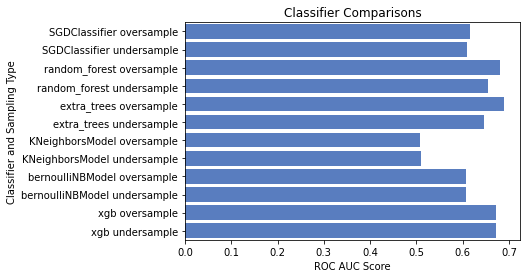

In [33]:
plt.title('Classifier Comparisons')
sns.set_color_codes("muted")
sns.barplot(x='roc_score', y='Classifier_Sample_Type', data=classifier_performance, color="b")
plt.xlabel('ROC AUC Score')
plt.ylabel('Classifier and Sampling Type')
plt.show()

Based upon this information, the classifier that I will use to make predictions on the test set will be the xgb which is trained on the oversampled data. Now I will train that classifier using all of the data.

In [34]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
xgb.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In order to get the test data into the correct position to make the predictions, I will need to perform the same feature engineering to the test dataset as I did to the training dataset. This would involve label encoding the label encoded columns, one hot encoding the one hot encoded columns, and encoding the other columns according to the dictionary that I created.

In [35]:
df_test

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,300000,0,0,1,T,Y,Blue,Triangle,Axolotl,Finland,Piano,0870b0a5d,9ceb19dd6,530f8ecc3,9d117320c,3c49b42b8,2,Novice,Warm,j,P,be,5,11
1,300001,0,0,0,T,N,Red,Square,Lion,Canada,Piano,a5c276589,1ad744242,12e6161c9,46ae3059c,285771075,1,Master,Lava Hot,l,A,RP,7,5
2,300002,1,0,1,F,Y,Blue,Square,Dog,China,Piano,568550f04,1fe17a1fd,27d6df03f,b759e21f0,6f323c53f,2,Expert,Freezing,a,G,tP,1,12
3,300003,0,0,1,T,Y,Red,Star,Cat,China,Piano,c5725677e,a6542cec0,30c63bd0c,0b6ec68ff,b5de3dcc4,1,Contributor,Lava Hot,b,Q,ke,2,3
4,300004,0,1,1,F,N,Red,Trapezoid,Dog,China,Piano,e70a6270d,97b6a3518,a42386065,f91f3b1ee,967cfa9c9,3,Grandmaster,Lava Hot,l,W,qK,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,0,0,0,F,N,Green,Square,Lion,Canada,Theremin,6c90f81cd,a406a5f12,d02a6b0ba,9e4b23160,acc31291f,1,Novice,Lava Hot,j,A,Gb,1,3
199996,499996,1,0,0,F,Y,Green,Trapezoid,Lion,China,Piano,2d61990e2,520806ce2,d2d8eabdb,cfbd87ed0,eae3446d0,1,Contributor,Lava Hot,f,S,Ed,2,2
199997,499997,0,1,1,T,Y,Green,Trapezoid,Lion,Canada,Oboe,488406659,28645754b,22831fffe,1108bcd6c,33dd3cf4b,1,Novice,Boiling Hot,g,V,TR,3,1
199998,499998,1,0,0,T,Y,Blue,Star,Hamster,Costa Rica,Bassoon,f9d17bb93,2eadb68c5,fef807a3e,606ac930b,d4cf587dd,2,Grandmaster,Boiling Hot,g,X,Ye,2,1


One Hot Encode the same columns as on the training set

In [36]:
# Create the one hot encoded dataframe using pd.get_dummies()
ohe_df = pd.get_dummies(df_test[ohe_cols])

# Join the columns from the one hot encoded dataframe to the training dataframe
df_test = df_test.join(ohe_df)

# Drop the old columns
df_test.drop(ohe_cols, axis=1, inplace=True)

Label encode the same colmns as on the training set using the same label encoders that were used on the training set. There were a few values in the test dataset which were not in the training dataset. So for each of the columns, I'm going to iterate through the DataFrame and replace any of the unknown labels with the text '<unknown>' and then append that label to the list of classes in the label encoder.

In [37]:
for col in encoders_dict.keys():
    le = encoders_dict[col]
    df_test[col] = df_test[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<unknown>')
    df_test[col] = le.transform(df_test[col])

Encode the rest of the columns according to the previously used dictionaries.

In [38]:
for col in ords_dict.keys():
    df_test[col] = df_test[col].map(ords_dict[col])

In [39]:
# drop the id column so that it is not included when making predictions
id_col = pd.DataFrame(df_test['id'])
df_test = df_test.drop(['id'], axis=1)

In [40]:
# make the predictions
predictions = xgb.predict(df_test)
predictions = pd.DataFrame(predictions)

In [41]:
predictions.head()

,0
0,1
1,1
2,0
3,1
4,1


In [42]:
# get the data into the correct format to make a submission
submission = pd.DataFrame(IDs, columns=['id'])
submission['target'] = predictions
submission

,id,target
0,300000,1
1,300001,1
2,300002,0
3,300003,1
4,300004,1
...,...,...
199995,499995,0
199996,499996,0
199997,499997,0
199998,499998,1


In [43]:
# convert the submission to csv and submit
submission.to_csv('submission.csv', index=False)

My final score was 0.70188. Top leaderboard scores are up to 0.80.